<b>Falling ball:</b>  
Considere la simulación de n-cuerpos vista en clase. Ajuste el número de partículas a $N = 1$ y radio $R = 2$ con las siguientes condiciones iniciales:  
     $$r_0 = (-15,-19)$$
     $$v_0 = (2,0)$$
     $$a_0 = (0,0)$$


Ajuste el área de la simulación a $A = 40 × 40$. La rutina de la interacción cuerpo-pared ya está incluida en los códigos de la clase. Suponga que en cada colisión contra la paredes se pierde una cierta cantidad de energía. Esta perdida es controlada por el coeficiente de restitución de la interacción cuerpo-pared:
$$
e=-\frac{v_2 - v_1}{u_2-u_1}=0.9
$$
$v$ se refiere a velocidades finales y $u$ a velocidades iniciales, en este caso, $u1 = v1 = 0$ dado que el piso no se mueve. En el método que verifica la existencia de las paredes, ajuste la condición del coeficiente de restitución. Para que se vea fluido debe reducir el tamaño de la simulación en un factor de 100.  
Usando el algoritmo de Euler-Cromer itere los primeros 30 segundos con un paso temporal de $\Delta t = 0.001$.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [5]:
class Particle:  
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        self.Ep = 0
        self.VEp = np.zeros(len(t))
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        self.SetPotentialEnergy(i)
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        
        
    def CalculateForce(self):
        
        self.f = self.m*np.array([0,-9.8])
        self.Ep += self.m*9.8*self.r[1]
        
    # Aca debes agregar la energía potencial
    
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        
    def SetPotentialEnergy(self,i):
        self.VEp[i] = self.Ep
        
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    
    def GetPotentialEnergy(self,scale=1):
        return self.VEp[::scale] 
    
    # Debes agregar las paredes en este punto
    def CheckLimits(self):
        
        for i in range(2):
            
            if self.r[i] + self.radius > 20 and self.v[i] > 0.:
                self.v[i] = -0.9*self.v[i]
            elif self.r[i] - self.radius < -20 and self.v[i] < 0.:
                self.v[i] = -0.9*self.v[i]

In [6]:
def GetParticles(t):
    
    r0 = np.array([-15.,-10.])
    v0 = np.array([2.,0])
    a0 = np.array([0.,0.])
    
    p0 = Particle(r0,v0,a0,t,m=1,radius=2,Id=0)
    
    Particles = [p0]
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return Particles

In [7]:
dt = 0.001
tmax = 30
t = np.arange(0,tmax,dt)
Particles = GetParticles(t)

In [8]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
                    Particles[i].CalculateForce()
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [9]:

Particles = RunSimulation(t,Particles)

Running simulation: 100%|█████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 18451.08 Steps/s]


In [10]:
# Bajamos dimensión de la simulacion
scale = 100
t1 = t[::scale]

<IPython.core.display.Javascript object>


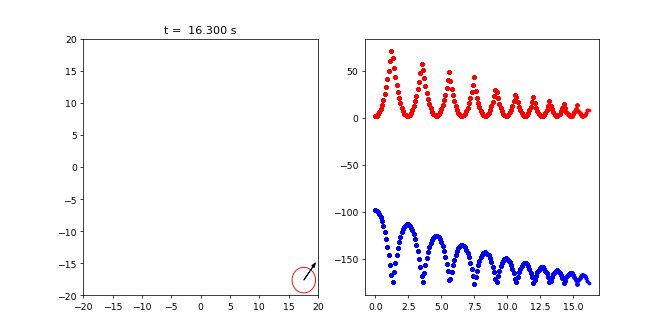

In [11]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    U = 0. # Potential energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        U +=p.GetPotentialEnergy(scale)[i]
        
        M = p.GetPotentialEnergy(scale)[:i] + p.GetKineticEnergy(scale)[:i]
        
        #ax1.set_title("K: {:.3f}, U: {:.3f}, M:{:.3f}".format(KE,Um,M))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='red',marker='.')
        ax1.scatter(t1[:i], p.GetPotentialEnergy(scale)[:i],color='blue',marker='.')
        #ax1.scatter(t1[:i], M ,color='green',marker='.')
            
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [12]:
y_position = Particles[0].GetPosition(scale)[:,1]

t_n = []

for i in range(len(y_position)-1):
    dif = y_position[i+1]-y_position[i]
    
    if np.isclose(dif,0,atol=1e-3):
        t_n.append(i)
        
t_f = t[::scale][t_n[0]]
t_f

22.7

In [13]:
y_max = []
y_position = Particles[0].GetPosition(scale)[:,1]

for i in range(1,len(y_position)-1):
    
    if y_position[i-1] < y_position[i] > y_position[i+1]:
        y_max.append(y_position[i])

y_max

[-11.536244079999994,
 -12.772390991999991,
 -13.778591174399995,
 -14.592562577119988,
 -15.244656072991987,
 -15.783624308408784,
 -16.20588452122909,
 -16.55103251162715,
 -16.830285092796732,
 -17.065434467364835,
 -17.24315149329067,
 -17.391349267464612,
 -17.50805516234232,
 -17.60451481897691,
 -17.688670700634628,
 -17.746921418140968,
 -17.805831286948635,
 -17.844162380013902,
 -17.869430913003473,
 -17.895453528395954,
 -17.91887689922975,
 -17.937260604697414,
 -17.958040942895817,
 -17.969106745008904,
 -17.977208985252048,
 -17.99459473013894]

In [14]:
rest = []
for i in range(len(y_max)-1):
    rest.append(np.sqrt(y_max[i+1]/y_max[i]))
rest

[1.052213535871294,
 1.0386430149881625,
 1.0291137361562184,
 1.0220991644841464,
 1.017523743393963,
 1.0132882402170849,
 1.0105927445254745,
 1.0084008206713198,
 1.0069616675127628,
 1.0051934435022394,
 1.0042880998466368,
 1.0033496756479627,
 1.0027509383737592,
 1.0023873292841918,
 1.0016452010669508,
 1.0016583457328923,
 1.001075784823749,
 1.0007077831196156,
 1.000727867285178,
 1.0006542363146138,
 1.0005128388581548,
 1.0005790829388101,
 1.0003080541462637,
 1.0002254237576276,
 1.0004834327591505]

In [15]:
np.array(rest).mean()

1.009015368211129